In [138]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

3.1

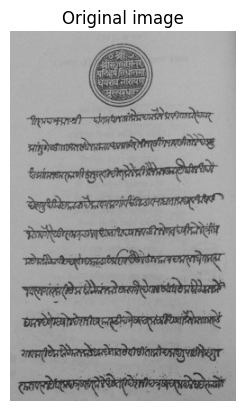

Dimensions: (411, 251, 3)
Pixel Value Range: 28 to 190
Color Channels Info:
  Red - Min: 28, Max: 190, Mean: 150.76
  Green - Min: 28, Max: 190, Mean: 150.76
  Blue - Min: 28, Max: 190, Mean: 150.76


In [139]:
def load_document_image(filepath):
    image = cv2.imread(filepath, cv2.IMREAD_COLOR)
    image_array = np.array(image)
     
    plt.imshow(image_array)
    plt.title("Original image")
    plt.axis("off")
    plt.show()
    
    print(f"Dimensions: {image.shape}")  # Shape of the image
    print(f"Pixel Value Range: {image_array.min()} to {image_array.max()}")
    
    # Separate channels for color image
    if len(image_array.shape) == 3:  # Color image
        print("Color Channels Info:")
        for i, channel in enumerate(['Red', 'Green', 'Blue']):
            channel_data = image_array[:, :, i]
            print(f"  {channel} - Min: {channel_data.min()}, Max: {channel_data.max()}, Mean: {channel_data.mean():.2f}")
    else:
        # Grayscale image
        print(f"Mean Pixel Value: {image_array.mean():.2f}")
        print(f"Standard Deviation: {image_array.std():.2f}")
        
    return image
    
image_path = "historical-doc.png"
image = load_document_image(image_path)

## Comparing histograms

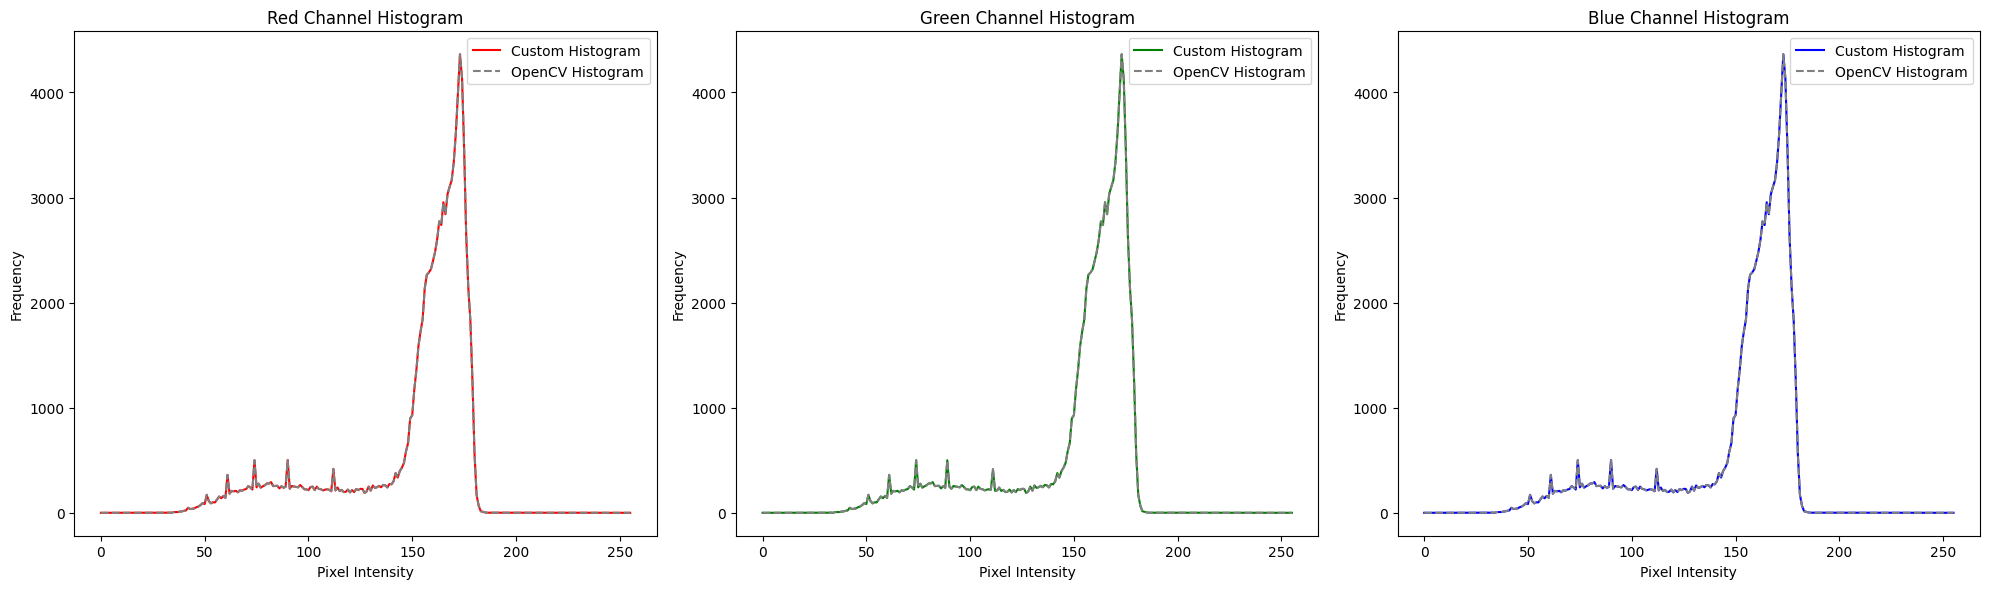

In [140]:
def custom_histogram(image, channel):
    """
    Compute the custom histogram for a specific channel of the image.
    """
    channel_data = image[:, :, channel]
    hist = np.zeros(256, dtype=int)  # Initialize histogram for 256 intensity levels
    
    for value in channel_data.flatten():
        hist[value] += 1
    
    return hist

def compare_histograms(image):
    # Check if the image is RGB
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Input image must be a 3-channel RGB image.")
    
    channel_labels = ['Red', 'Green', 'Blue']
    colors = ['r', 'g', 'b']  
    
    plt.figure(figsize=(20, 6))
    
    for channel in range(3):  
        # Compute custom histogram
        custom_hist = custom_histogram(image, channel)
        
        # Compute OpenCV histogram
        opencv_hist = cv2.calcHist([image], [channel], None, [256], [0, 256]).flatten()
        
        plt.subplot(1, 3, channel + 1)
        plt.plot(custom_hist, label='Custom Histogram', linestyle='solid', color=colors[channel])
        plt.plot(opencv_hist, label='OpenCV Histogram', linestyle='dashed', color='gray')
        plt.title(f"{channel_labels[channel]} Channel Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        
    plt.show()
    
compare_histograms(image)


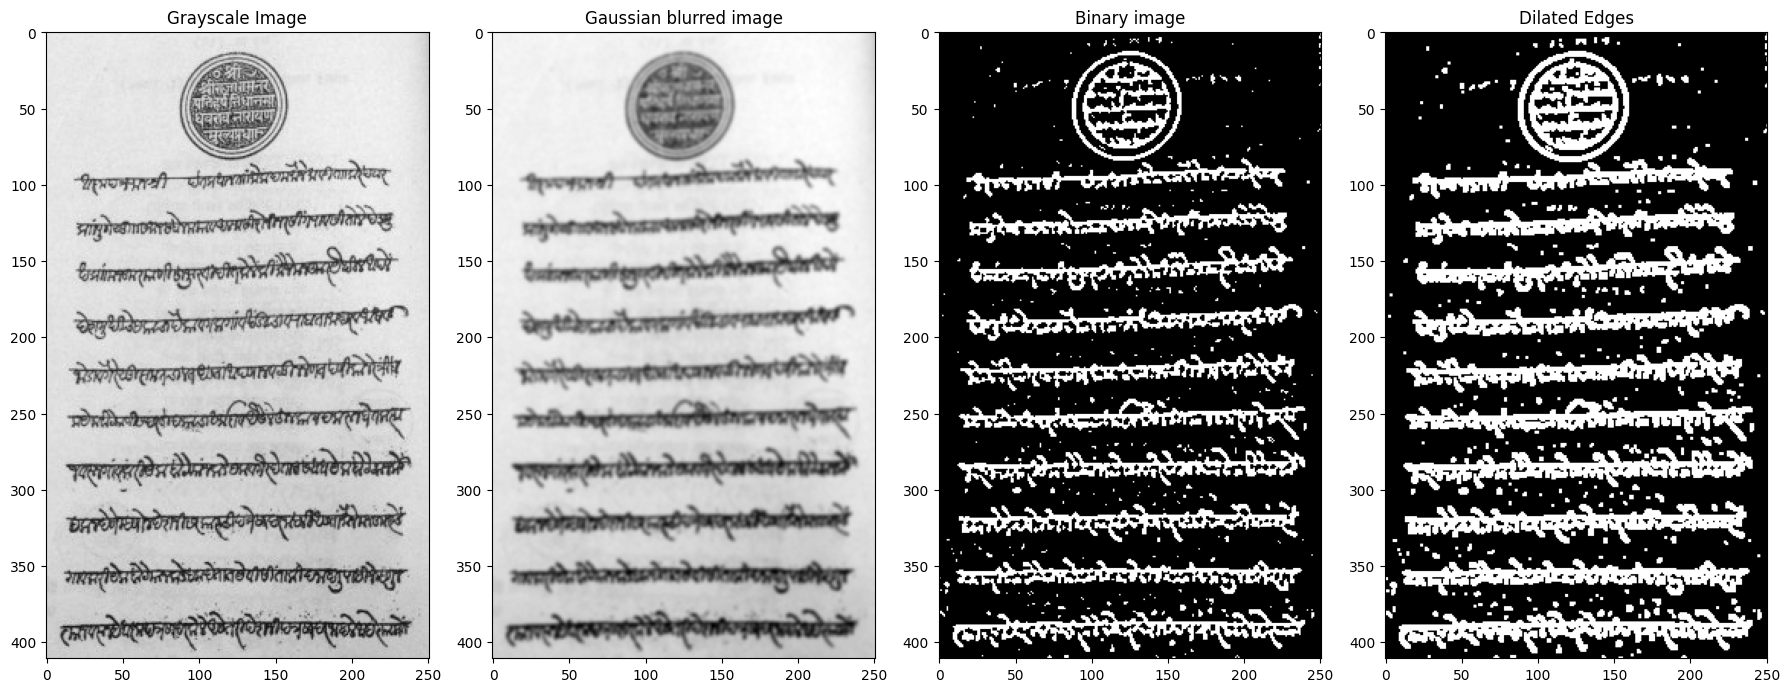

In [141]:
def preprocess_image(image):
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5,5), 0)
    
    # convert to binary
    binary_image = cv2.adaptiveThreshold(
        blurred_image, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 
        11, 2
    )
    
    # dilate the image
    kernel = np.ones((2, 2), np.uint8)
    dilated = cv2.dilate(binary_image, kernel, iterations=1)
    
    plt.figure(figsize = (18, 8))
    
    plt.subplot(1,4,1)
    plt.imshow(gray_image, cmap='gray')
    plt.title("Grayscale Image")
    
    plt.subplot(1,4,2)
    plt.imshow(blurred_image, cmap='gray')
    plt.title("Gaussian blurred image")

   
    plt.subplot(1,4,3)
    plt.imshow(binary_image, cmap='gray')
    plt.title("Binary image")

    plt.subplot(1,4,4)
    plt.imshow(dilated, cmap='gray')
    plt.title("Dilated Edges")

    plt.tight_layout()
    plt.show
    return dilated
processed_image = preprocess_image(image)

#### Detecting bounding boxes

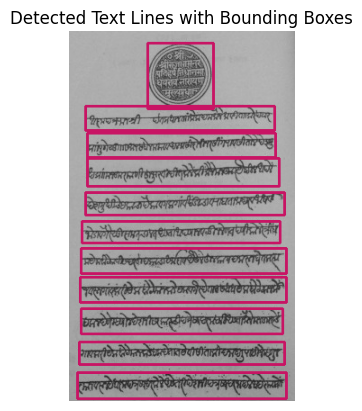

Saved 11 text line images.


In [142]:
def detect_lines_with_bboxes(preprocessed_image, original_image, minheight = 10, minwidth = 50, seal = False):
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(preprocessed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    image_with_bboxes = original_image.copy()
    
    # counter for saving cropped lines
    line_counter = 1
    
    for contour in contours:
        # Get the bounding box coordinates
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter out small contours that may not be text lines
        if w > minwidth and h > minheight:
            # Draw the bounding box on the image
            cv2.rectangle(image_with_bboxes, (x, y), (x + w, y + h), (100, 20, 200), 2)
            
            # Crop the text line from the original image
            cropped_line = original_image[y:y + h, x:x + w]
            
            if(seal is False):
                cv2.imwrite(f"bounded_boxes/line_{line_counter}.png", cropped_line)
            else:
                cv2.imwrite(f"bounded_boxes_on_seal/line_{line_counter}.png", cropped_line)
                
            line_counter += 1

    plt.imshow(cv2.cvtColor(image_with_bboxes, cv2.COLOR_BGR2RGB))
    plt.title("Detected Text Lines with Bounding Boxes")
    plt.axis("off")
    plt.show()
    
    print(f"Saved {line_counter - 1} text line images.")
    return image_with_bboxes

image_with_bboxes = detect_lines_with_bboxes(processed_image, image, 10, 50, False)    

### Detecting boxes within the seal

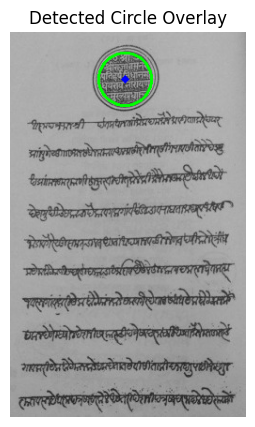

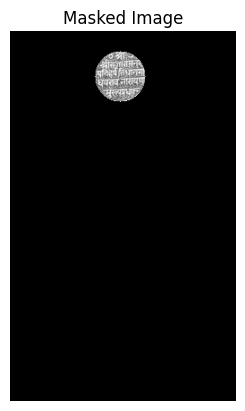

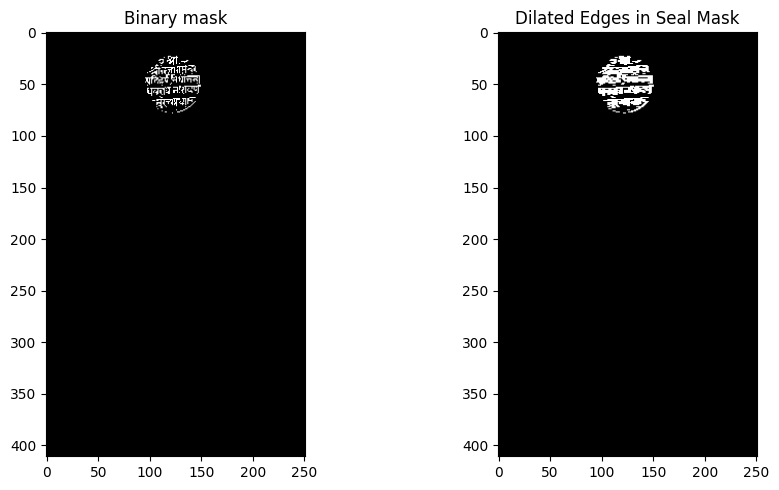

In [158]:
def preprocess_seal(image):
    _, thresh = cv2.threshold(image, 130, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 1))
    dilated = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(thresh, cmap='gray')
    plt.title("Binary mask")

    plt.subplot(1, 2, 2)
    plt.imshow(dilated, cmap='gray')
    plt.title("Dilated Edges in Seal Mask")

    plt.tight_layout()
    plt.show()

    return dilated


def segment_lines_in_seal(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect circles
    circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2
                               , minDist=100,
                               param1=100, param2=30, minRadius=20, maxRadius=29)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Get the circle parameters
            center_x, center_y, radius = i[0], i[1], i[2]

            # Draw the detected circle on the original image
            overlay_image = image.copy()
            cv2.circle(overlay_image, (center_x, center_y), radius, (0, 255, 0), 2)  
            cv2.circle(overlay_image, (center_x, center_y), 2, (255, 0, 0), 3) 

            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
            plt.title("Detected Circle Overlay")
            plt.axis('off')
            plt.show()

            # Create a mask for the circular region
            mask = np.zeros_like(gray_image)
            cv2.circle(mask, (center_x, center_y), radius, 255, -1)

            # Mask the original image
            masked_image = cv2.bitwise_and(gray_image, gray_image, mask=mask)

            plt.imshow(masked_image, cmap='gray')
            plt.title("Masked Image")
            plt.axis('off')
            plt.show()

            # Process the masked image
            processed_image = preprocess_seal(masked_image)
            return processed_image

# Example usage
processed_image_for_seal = segment_lines_in_seal(image)


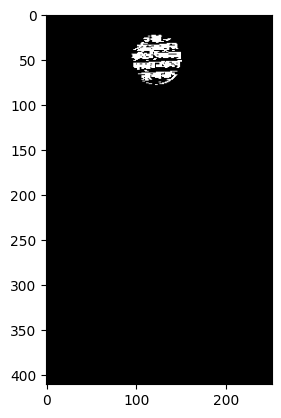

In [159]:
plt.imshow(processed_image_for_seal, cmap='gray')

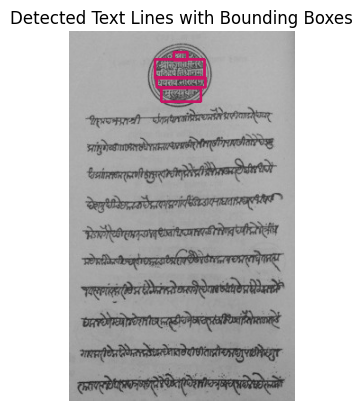

Saved 4 text line images.


In [160]:
seal_with_bboxes = detect_lines_with_bboxes(processed_image_for_seal, image, 4, 7, True)

### Detect lines using polygon

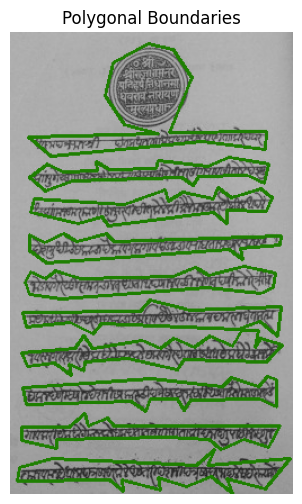

In [ ]:
def preprocess_image_for_polygon(image):
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5,5), 3)
    binary_image = cv2.adaptiveThreshold(
        blurred_image, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 
        11, 2
    )
    
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(binary_image, kernel, iterations=1)
    return dilated

def detect_lines_with_polygons(image, epsilon_factor=0.01):
    binary = preprocess_image_for_polygon(image)
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    bounding_boxes = []

    for contour in contours:
        # Polygonal approximation
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        polygon_area = cv2.contourArea(polygon)
        if(polygon_area > 80):
            polygons.append(polygon)

        # Bounding box for comparison
        x, y, w, h = cv2.boundingRect(contour)
        if(w > 10 and h > 5):
            bounding_boxes.append((x, y, w, h))

    return polygons, bounding_boxes

def display_results(image, polygons, bounding_boxes):
    
    # Create copies of the image for visualization
    image_with_polygons = image.copy()
    image_with_bounding_boxes = image.copy()

    # Draw polygons
    for polygon in polygons:
        cv2.polylines(image_with_polygons, [polygon], isClosed=True, color=(1, 128, 30), thickness=2)

    # Draw bounding boxes
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(image_with_bounding_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Display results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 1, 1)
    plt.title("Polygonal Boundaries")
    plt.imshow(cv2.cvtColor(image_with_polygons, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()

polygons, bounding_boxes = detect_lines_with_polygons(image)

# Display results
display_results(image, polygons, bounding_boxes)

### Advantages of Polygons:

+ Polygons adapt better to curved or irregular text shapes, improving segmentation precision.
+ They minimize the inclusion of non-text regions compared to rectangles.
+ Ideal for dense or overlapping text lines.

### Disadvantages of Polygons:

+ Detecting and drawing polygons is computationally more expensive than rectangles.
+ Fine-tuning parameters (e.g., epsilon in cv2.approxPolyDP) is necessary to balance precision and over-segmentation.
+ Complex shapes may introduce errors if text boundaries are not well-defined.

Impact on Results:

1. For clear, regular text, polygons provide marginal improvement over rectangles.
2. For curved or irregular text, polygons significantly enhance segmentation accuracy.